## 1. Environment Setup <a id="1-environment-setup"></a>

In [10]:
!pip install torch transformers numpy pandas scipy matplotlib seaborn tqdm


[notice] A new release of pip is available: 25.1.1 -> 26.0.1
[notice] To update, run: C:\Users\kowlin\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [11]:
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import os
import time
import json
import copy
import warnings
from datetime import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

PyTorch Version: 2.7.0+cpu
CUDA Available: False
Device: cpu


In [12]:
CONFIG = {
    "model_id": "./finetuned-model/indobert-fp32-smsa-3label-finetuned",
    "labels": {0: "POSITIVE", 1: "NEUTRAL", 2: "NEGATIVE"},
    
    "quantization_dtype": torch.qint8,
    "target_layers": {torch.nn.Linear},
    
    "num_inference_runs": 2,
    "warmup_runs": 5,
    
    "output_dir": "./finetuned-tweets-outputs",
    "timestamp": datetime.now().strftime("%Y%m%d_%H%M%S")
}

os.makedirs(CONFIG["output_dir"], exist_ok=True)

print("Configuration loaded successfully.")
print(f"Output directory: {os.path.abspath(CONFIG['output_dir'])}")

Configuration loaded successfully.
Output directory: c:\BINUS\COOLYEAH\model-quantization-sentiment-analysis\quantization-ptq\src\standard-quantization\finetuned-tweets-outputs


## 2. Model Loading <a id="2-model-loading"></a>

In [13]:
print(f"Loading model: {CONFIG['model_id']}")
print("="*60)

tokenizer = AutoTokenizer.from_pretrained(CONFIG["model_id"])
model_fp32 = AutoModelForSequenceClassification.from_pretrained(
    CONFIG["model_id"],
    num_labels=len(CONFIG["labels"]),
    ignore_mismatched_sizes=True
)

model_fp32.eval()

print(f"\n✓ Model loaded successfully")
print(f"  - Architecture: {model_fp32.config.model_type}")
print(f"  - Hidden Size: {model_fp32.config.hidden_size}")
print(f"  - Num Labels: {model_fp32.config.num_labels}")
print(f"  - Vocab Size: {model_fp32.config.vocab_size}")

Loading model: ./finetuned-model/indobert-fp32-smsa-3label-finetuned


Loading weights: 100%|██████████| 201/201 [00:00<00:00, 814.38it/s, Materializing param=classifier.weight]                                      
BertForSequenceClassification LOAD REPORT from: ./finetuned-model/indobert-fp32-smsa-3label-finetuned
Key                          | Status     |  | 
-----------------------------+------------+--+-
bert.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.



✓ Model loaded successfully
  - Architecture: bert
  - Hidden Size: 768
  - Num Labels: 3
  - Vocab Size: 50000


In [14]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

total_params, trainable_params = count_parameters(model_fp32)

print("\n" + "="*60)
print("MODEL PARAMETER SUMMARY")
print("="*60)
print(f"Total Parameters:     {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Frozen Parameters:    {total_params - trainable_params:,}")


MODEL PARAMETER SUMMARY
Total Parameters:     124,443,651
Trainable Parameters: 124,443,651
Frozen Parameters:    0


## 3. Baseline Evaluation (FP32) <a id="3-baseline-evaluation-fp32"></a>

In [15]:
file_path = "./datasets/INA_TweetsPPKM_Labeled_Pure.csv"
print(f"Loading dataset from: {file_path}")

df = pd.read_csv(file_path, sep="\t", engine="python")

df_sample = df.sample(frac=1/20, random_state=42)

print(f"Total rows in dataset: {len(df)}")
print(f"Sampled rows (1/20): {len(df_sample)}")

sentiment_map = CONFIG["labels"]

TEST_SAMPLES = []
for _, row in df_sample.iterrows():
    try:
        sentiment_id = int(row['sentiment'])
        if sentiment_id in sentiment_map:
            TEST_SAMPLES.append({
                "text": row['Tweet'],
                "expected": sentiment_map[sentiment_id]
            })
    except ValueError:
        continue

print(f"Prepared {len(TEST_SAMPLES)} test samples from CSV:")
print(f"  - Positive: {sum(1 for s in TEST_SAMPLES if s['expected'] == 'POSITIVE')}")
print(f"  - Negative: {sum(1 for s in TEST_SAMPLES if s['expected'] == 'NEGATIVE')}")
print(f"  - Neutral: {sum(1 for s in TEST_SAMPLES if s['expected'] == 'NEUTRAL')}")

Loading dataset from: ./datasets/INA_TweetsPPKM_Labeled_Pure.csv
Total rows in dataset: 23644
Sampled rows (1/20): 1182
Prepared 1182 test samples from CSV:
  - Positive: 95
  - Negative: 193
  - Neutral: 894


In [16]:
def predict(model, text, tokenizer=tokenizer, labels=CONFIG["labels"], use_fp16=False):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    
    if use_fp16:
        inputs = {k: v.half() if v.dtype == torch.float32 else v for k, v in inputs.items()}
    
    start_time = time.perf_counter()
    with torch.no_grad():
        outputs = model(**inputs)
    end_time = time.perf_counter()
    
    logits = outputs.logits.float()
    probabilities = torch.softmax(logits, dim=1)[0]
    predicted_class_id = logits.argmax().item()
    confidence = probabilities[predicted_class_id].item()
    
    return {
        "label": labels[predicted_class_id],
        "class_id": predicted_class_id,
        "confidence": confidence,
        "probabilities": {labels[i]: prob.item() for i, prob in enumerate(probabilities)},
        "inference_time": end_time - start_time
    }

test_result = predict(model_fp32, "Ini adalah tes.")
print("Prediction function tested successfully.")
print(f"Sample result: {test_result['label']} (confidence: {test_result['confidence']:.4f})")

Prediction function tested successfully.
Sample result: NEUTRAL (confidence: 0.9740)


In [17]:
def evaluate_model(model, samples, num_runs=CONFIG["num_inference_runs"], warmup=CONFIG["warmup_runs"], use_fp16=False):
    results = {
        "predictions": [],
        "latencies": [],
        "accuracy": 0,
        "avg_confidence": 0,
    }
    
    correct = 0
    total_confidence = 0
    
    total_inferences = len(samples) * (warmup + num_runs + 1)
    print(f"Total samples: {len(samples)}")
    print(f"Total inference operations: {total_inferences:,}\n")
    
    pbar = tqdm(samples, desc="Evaluating samples", unit="sample")
    
    for sample in pbar:
        for _ in range(warmup):
            _ = predict(model, sample["text"], use_fp16=use_fp16)
        
        sample_latencies = []
        for _ in range(num_runs):
            pred = predict(model, sample["text"], use_fp16=use_fp16)
            sample_latencies.append(pred["inference_time"])
        
        final_pred = predict(model, sample["text"], use_fp16=use_fp16)
        
        results["predictions"].append({
            "text": sample["text"],
            "expected": sample["expected"],
            "predicted": final_pred["label"],
            "confidence": final_pred["confidence"],
            "probabilities": final_pred["probabilities"],
            "avg_latency": np.mean(sample_latencies),
            "std_latency": np.std(sample_latencies)
        })
        
        results["latencies"].extend(sample_latencies)
        
        if final_pred["label"] == sample["expected"]:
            correct += 1
        total_confidence += final_pred["confidence"]
        
        current_accuracy = correct / len(results["predictions"])
        pbar.set_postfix({
            "Accuracy": f"{current_accuracy:.2%}",
            "Correct": f"{correct}/{len(results['predictions'])}"
        })
    
    results["accuracy"] = correct / len(samples)
    results["avg_confidence"] = total_confidence / len(samples)
    results["latency_stats"] = {
        "mean": np.mean(results["latencies"]),
        "std": np.std(results["latencies"]),
        "min": np.min(results["latencies"]),
        "max": np.max(results["latencies"]),
        "median": np.median(results["latencies"])
    }
    
    return results

print("Evaluation function with progress tracking defined.")

Evaluation function with progress tracking defined.


In [18]:
print("="*60)
print("BASELINE EVALUATION (FP32 Model)")
print("="*60)
print(f"Running {CONFIG['num_inference_runs']} inference iterations per sample...")
print(f"Warmup runs: {CONFIG['warmup_runs']}\n")

fp32_results = evaluate_model(model_fp32, TEST_SAMPLES)

print("\n" + "-"*60)
print("BASELINE RESULTS SUMMARY")
print("-"*60)
print(f"Accuracy:         {fp32_results['accuracy']*100:.2f}%")
print(f"Avg Confidence:   {fp32_results['avg_confidence']*100:.2f}%")
print(f"\nLatency Statistics:")
print(f"  Mean:   {fp32_results['latency_stats']['mean']*1000:.2f} ms")
print(f"  Std:    {fp32_results['latency_stats']['std']*1000:.2f} ms")
print(f"  Median: {fp32_results['latency_stats']['median']*1000:.2f} ms")
print(f"  Min:    {fp32_results['latency_stats']['min']*1000:.2f} ms")
print(f"  Max:    {fp32_results['latency_stats']['max']*1000:.2f} ms")

BASELINE EVALUATION (FP32 Model)
Running 2 inference iterations per sample...
Warmup runs: 5

Total samples: 1182
Total inference operations: 9,456



Evaluating samples: 100%|██████████| 1182/1182 [10:47<00:00,  1.83sample/s, Accuracy=82.23%, Correct=972/1182]


------------------------------------------------------------
BASELINE RESULTS SUMMARY
------------------------------------------------------------
Accuracy:         82.23%
Avg Confidence:   93.01%

Latency Statistics:
  Mean:   67.44 ms
  Std:    32.61 ms
  Median: 62.88 ms
  Min:    27.70 ms
  Max:    381.18 ms


In [19]:
fp32_path = os.path.join(CONFIG["output_dir"], "model_fp32.pth")
torch.save(model_fp32.state_dict(), fp32_path)
fp32_size_mb = os.path.getsize(fp32_path) / (1024 * 1024)

print(f"\n✓ FP32 model saved: {fp32_path}")
print(f"  Model Size: {fp32_size_mb:.2f} MB")


✓ FP32 model saved: ./finetuned-tweets-outputs\model_fp32.pth
  Model Size: 474.79 MB


## 4. Half-Precision (FP16) <a id="4-half-precision-fp16"></a>

In [20]:
print("="*60)
print("HALF-PRECISION CONVERSION (FP16)")
print("="*60)
print("Converting FP32 model to FP16 (half-precision)...\n")

model_fp16 = copy.deepcopy(model_fp32)
model_fp16 = model_fp16.half()
model_fp16.eval()

print("✓ FP16 model created successfully")

HALF-PRECISION CONVERSION (FP16)
Converting FP32 model to FP16 (half-precision)...

✓ FP16 model created successfully


In [21]:
fp16_path = os.path.join(CONFIG["output_dir"], "model_fp16.pth")
torch.save(model_fp16.state_dict(), fp16_path)
fp16_size_mb = os.path.getsize(fp16_path) / (1024 * 1024)

print(f"✓ FP16 model saved: {fp16_path}")
print(f"  Model Size: {fp16_size_mb:.2f} MB")
print(f"  Size Reduction: {(1 - fp16_size_mb/fp32_size_mb)*100:.2f}%")

✓ FP16 model saved: ./finetuned-tweets-outputs\model_fp16.pth
  Model Size: 237.43 MB
  Size Reduction: 49.99%


In [22]:
print("="*60)
print("FP16 MODEL EVALUATION")
print("="*60)
print(f"Running {CONFIG['num_inference_runs']} inference iterations per sample...\n")

fp16_results = evaluate_model(model_fp16, TEST_SAMPLES, use_fp16=True)

print("\n" + "-"*60)
print("FP16 RESULTS SUMMARY")
print("-"*60)
print(f"Accuracy:         {fp16_results['accuracy']*100:.2f}%")
print(f"Avg Confidence:   {fp16_results['avg_confidence']*100:.2f}%")
print(f"\nLatency Statistics:")
print(f"  Mean:   {fp16_results['latency_stats']['mean']*1000:.2f} ms")
print(f"  Std:    {fp16_results['latency_stats']['std']*1000:.2f} ms")
print(f"  Median: {fp16_results['latency_stats']['median']*1000:.2f} ms")
print(f"  Min:    {fp16_results['latency_stats']['min']*1000:.2f} ms")
print(f"  Max:    {fp16_results['latency_stats']['max']*1000:.2f} ms")

FP16 MODEL EVALUATION
Running 2 inference iterations per sample...

Total samples: 1182
Total inference operations: 9,456



Evaluating samples: 100%|██████████| 1182/1182 [47:12<00:00,  2.40s/sample, Accuracy=82.23%, Correct=972/1182]


------------------------------------------------------------
FP16 RESULTS SUMMARY
------------------------------------------------------------
Accuracy:         82.23%
Avg Confidence:   93.01%

Latency Statistics:
  Mean:   298.31 ms
  Std:    151.01 ms
  Median: 279.91 ms
  Min:    53.57 ms
  Max:    2055.35 ms


## 5. Dynamic Quantization (INT8) <a id="5-dynamic-quantization-int8"></a>

In [23]:
print("="*60)
print("APPLYING DYNAMIC QUANTIZATION")
print("="*60)
print(f"Target Layers: {CONFIG['target_layers']}")
print(f"Target Dtype:  {CONFIG['quantization_dtype']}")
print()

quantization_start = time.perf_counter()
model_int8 = torch.quantization.quantize_dynamic(
    model_fp32,
    CONFIG["target_layers"],
    dtype=CONFIG["quantization_dtype"]
)
quantization_time = time.perf_counter() - quantization_start

print(f"✓ Quantization completed in {quantization_time:.2f} seconds")

APPLYING DYNAMIC QUANTIZATION
Target Layers: {<class 'torch.nn.modules.linear.Linear'>}
Target Dtype:  torch.qint8

✓ Quantization completed in 1.73 seconds


In [24]:
int8_path = os.path.join(CONFIG["output_dir"], "model_int8.pth")
torch.save(model_int8.state_dict(), int8_path)
int8_size_mb = os.path.getsize(int8_path) / (1024 * 1024)

print(f"✓ INT8 model saved: {int8_path}")
print(f"  Model Size: {int8_size_mb:.2f} MB")
print(f"  Size Reduction: {(1 - int8_size_mb/fp32_size_mb)*100:.2f}%")

✓ INT8 model saved: ./finetuned-tweets-outputs\model_int8.pth
  Model Size: 230.15 MB
  Size Reduction: 51.53%


In [25]:
print("="*60)
print("QUANTIZED MODEL EVALUATION (INT8)")
print("="*60)
print(f"Running {CONFIG['num_inference_runs']} inference iterations per sample...\n")

int8_results = evaluate_model(model_int8, TEST_SAMPLES)

print("\n" + "-"*60)
print("INT8 RESULTS SUMMARY")
print("-"*60)
print(f"Accuracy:         {int8_results['accuracy']*100:.2f}%")
print(f"Avg Confidence:   {int8_results['avg_confidence']*100:.2f}%")
print(f"\nLatency Statistics:")
print(f"  Mean:   {int8_results['latency_stats']['mean']*1000:.2f} ms")
print(f"  Std:    {int8_results['latency_stats']['std']*1000:.2f} ms")
print(f"  Median: {int8_results['latency_stats']['median']*1000:.2f} ms")
print(f"  Min:    {int8_results['latency_stats']['min']*1000:.2f} ms")
print(f"  Max:    {int8_results['latency_stats']['max']*1000:.2f} ms")

QUANTIZED MODEL EVALUATION (INT8)
Running 2 inference iterations per sample...

Total samples: 1182
Total inference operations: 9,456



Evaluating samples: 100%|██████████| 1182/1182 [18:14<00:00,  1.08sample/s, Accuracy=81.90%, Correct=968/1182]


------------------------------------------------------------
INT8 RESULTS SUMMARY
------------------------------------------------------------
Accuracy:         81.90%
Avg Confidence:   92.90%

Latency Statistics:
  Mean:   114.03 ms
  Std:    25.04 ms
  Median: 111.84 ms
  Min:    56.69 ms
  Max:    250.98 ms


## 5.5 INT4 Quantization <a id="5.5-int4-quantization"></a>

In [26]:
class INT4Quantizer:
    
    def __init__(self, bits=4):
        self.bits = bits
        self.qmin = -(2 ** (bits - 1))
        self.qmax = 2 ** (bits - 1) - 1
        
    def quantize_tensor(self, tensor):
        tensor_float = tensor.float()
        
        abs_max = tensor_float.abs().max()
        if abs_max == 0:
            return torch.zeros_like(tensor_float, dtype=torch.int8), torch.tensor(1.0)
        
        scale = abs_max / self.qmax
        
        quantized = torch.clamp(torch.round(tensor_float / scale), self.qmin, self.qmax)
        quantized = quantized.to(torch.int8)
        
        return quantized, scale
    
    def dequantize_tensor(self, quantized, scale):
        return quantized.float() * scale


class INT4Linear(nn.Module):
    
    def __init__(self, original_linear, quantizer):
        super().__init__()
        self.in_features = original_linear.in_features
        self.out_features = original_linear.out_features
        
        weight_quantized, weight_scale = quantizer.quantize_tensor(original_linear.weight.data)
        self.register_buffer('weight_quantized', weight_quantized)
        self.register_buffer('weight_scale', weight_scale)
        
        if original_linear.bias is not None:
            self.register_buffer('bias', original_linear.bias.data.clone())
        else:
            self.register_buffer('bias', None)
        
        self.quantizer = quantizer
    
    def forward(self, x):
        weight_dequant = self.quantizer.dequantize_tensor(self.weight_quantized, self.weight_scale)
        return nn.functional.linear(x, weight_dequant, self.bias)


def quantize_model_int4(model):
    quantizer = INT4Quantizer(bits=4)
    model_int4 = copy.deepcopy(model)
    
    def replace_linear_with_int4(module, name=''):
        for child_name, child in module.named_children():
            if isinstance(child, nn.Linear):
                int4_linear = INT4Linear(child, quantizer)
                setattr(module, child_name, int4_linear)
            else:
                replace_linear_with_int4(child, f"{name}.{child_name}" if name else child_name)
    
    replace_linear_with_int4(model_int4)
    return model_int4


print("INT4 Quantization classes defined successfully.")

INT4 Quantization classes defined successfully.


In [27]:
print("="*60)
print("APPLYING INT4 QUANTIZATION")
print("="*60)
print("Target Layers: Linear")
print("Target Bits:   4")
print()

int4_quantization_start = time.perf_counter()
model_int4 = quantize_model_int4(model_fp32)
model_int4.eval()
int4_quantization_time = time.perf_counter() - int4_quantization_start

print(f"INT4 Quantization completed in {int4_quantization_time:.2f} seconds")

APPLYING INT4 QUANTIZATION
Target Layers: Linear
Target Bits:   4

INT4 Quantization completed in 0.56 seconds


In [28]:
int4_path = os.path.join(CONFIG["output_dir"], "model_int4.pth")
torch.save(model_int4.state_dict(), int4_path)
int4_size_mb = os.path.getsize(int4_path) / (1024 * 1024)

print(f"INT4 model saved: {int4_path}")
print(f"  Model Size: {int4_size_mb:.2f} MB")
print(f"  Size Reduction: {(1 - int4_size_mb/fp32_size_mb)*100:.2f}%")

INT4 model saved: ./finetuned-tweets-outputs\model_int4.pth
  Model Size: 230.12 MB
  Size Reduction: 51.53%


In [29]:
print("="*60)
print("QUANTIZED MODEL EVALUATION (INT4)")
print("="*60)
print(f"Running {CONFIG['num_inference_runs']} inference iterations per sample...\n")

int4_results = evaluate_model(model_int4, TEST_SAMPLES)

print("\n" + "-"*60)
print("INT4 RESULTS SUMMARY")
print("-"*60)
print(f"Accuracy:         {int4_results['accuracy']*100:.2f}%")
print(f"Avg Confidence:   {int4_results['avg_confidence']*100:.2f}%")
print(f"\nLatency Statistics:")
print(f"  Mean:   {int4_results['latency_stats']['mean']*1000:.2f} ms")
print(f"  Std:    {int4_results['latency_stats']['std']*1000:.2f} ms")
print(f"  Median: {int4_results['latency_stats']['median']*1000:.2f} ms")
print(f"  Min:    {int4_results['latency_stats']['min']*1000:.2f} ms")
print(f"  Max:    {int4_results['latency_stats']['max']*1000:.2f} ms")

QUANTIZED MODEL EVALUATION (INT4)
Running 2 inference iterations per sample...

Total samples: 1182
Total inference operations: 9,456



Evaluating samples: 100%|██████████| 1182/1182 [32:19<00:00,  1.64s/sample, Accuracy=83.67%, Correct=989/1182]


------------------------------------------------------------
INT4 RESULTS SUMMARY
------------------------------------------------------------
Accuracy:         83.67%
Avg Confidence:   91.54%

Latency Statistics:
  Mean:   204.19 ms
  Std:    37.02 ms
  Median: 203.40 ms
  Min:    111.16 ms
  Max:    344.65 ms


## 6. Comparative Analysis <a id="6-comparative-analysis"></a>

In [30]:
comparison_data = {
    "Metric": [
        "Model Size (MB)",
        "Accuracy (%)",
        "Avg Confidence (%)",
        "Mean Latency (ms)",
        "Median Latency (ms)",
        "Std Latency (ms)"
    ],
    "FP32 (Baseline)": [
        f"{fp32_size_mb:.2f}",
        f"{fp32_results['accuracy']*100:.2f}",
        f"{fp32_results['avg_confidence']*100:.2f}",
        f"{fp32_results['latency_stats']['mean']*1000:.2f}",
        f"{fp32_results['latency_stats']['median']*1000:.2f}",
        f"{fp32_results['latency_stats']['std']*1000:.2f}"
    ],
    "FP16 (Half)": [
        f"{fp16_size_mb:.2f}",
        f"{fp16_results['accuracy']*100:.2f}",
        f"{fp16_results['avg_confidence']*100:.2f}",
        f"{fp16_results['latency_stats']['mean']*1000:.2f}",
        f"{fp16_results['latency_stats']['median']*1000:.2f}",
        f"{fp16_results['latency_stats']['std']*1000:.2f}"
    ],
    "INT8 (Quantized)": [
        f"{int8_size_mb:.2f}",
        f"{int8_results['accuracy']*100:.2f}",
        f"{int8_results['avg_confidence']*100:.2f}",
        f"{int8_results['latency_stats']['mean']*1000:.2f}",
        f"{int8_results['latency_stats']['median']*1000:.2f}",
        f"{int8_results['latency_stats']['std']*1000:.2f}"
    ],
    "INT4 (4-bit)": [
        f"{int4_size_mb:.2f}",
        f"{int4_results['accuracy']*100:.2f}",
        f"{int4_results['avg_confidence']*100:.2f}",
        f"{int4_results['latency_stats']['mean']*1000:.2f}",
        f"{int4_results['latency_stats']['median']*1000:.2f}",
        f"{int4_results['latency_stats']['std']*1000:.2f}"
    ],
    "FP16 vs FP32": [
        f"{(1 - fp16_size_mb/fp32_size_mb)*100:+.2f}%",
        f"{(fp16_results['accuracy'] - fp32_results['accuracy'])*100:+.2f}%",
        f"{(fp16_results['avg_confidence'] - fp32_results['avg_confidence'])*100:+.2f}%",
        f"{((fp16_results['latency_stats']['mean'] - fp32_results['latency_stats']['mean'])/fp32_results['latency_stats']['mean'])*100:+.2f}%",
        f"{((fp16_results['latency_stats']['median'] - fp32_results['latency_stats']['median'])/fp32_results['latency_stats']['median'])*100:+.2f}%",
        "N/A"
    ],
    "INT8 vs FP32": [
        f"{(1 - int8_size_mb/fp32_size_mb)*100:+.2f}%",
        f"{(int8_results['accuracy'] - fp32_results['accuracy'])*100:+.2f}%",
        f"{(int8_results['avg_confidence'] - fp32_results['avg_confidence'])*100:+.2f}%",
        f"{((int8_results['latency_stats']['mean'] - fp32_results['latency_stats']['mean'])/fp32_results['latency_stats']['mean'])*100:+.2f}%",
        f"{((int8_results['latency_stats']['median'] - fp32_results['latency_stats']['median'])/fp32_results['latency_stats']['median'])*100:+.2f}%",
        "N/A"
    ],
    "INT4 vs FP32": [
        f"{(1 - int4_size_mb/fp32_size_mb)*100:+.2f}%",
        f"{(int4_results['accuracy'] - fp32_results['accuracy'])*100:+.2f}%",
        f"{(int4_results['avg_confidence'] - fp32_results['avg_confidence'])*100:+.2f}%",
        f"{((int4_results['latency_stats']['mean'] - fp32_results['latency_stats']['mean'])/fp32_results['latency_stats']['mean'])*100:+.2f}%",
        f"{((int4_results['latency_stats']['median'] - fp32_results['latency_stats']['median'])/fp32_results['latency_stats']['median'])*100:+.2f}%",
        "N/A"
    ]
}

df_comparison = pd.DataFrame(comparison_data)

print("\n" + "="*120)
print("QUANTIZATION COMPARISON SUMMARY (FP32 vs FP16 vs INT8 vs INT4)")
print("="*120)
print(df_comparison.to_string(index=False))
print("="*120)


QUANTIZATION COMPARISON SUMMARY (FP32 vs FP16 vs INT8 vs INT4)
             Metric FP32 (Baseline) FP16 (Half) INT8 (Quantized) INT4 (4-bit) FP16 vs FP32 INT8 vs FP32 INT4 vs FP32
    Model Size (MB)          474.79      237.43           230.15       230.12      +49.99%      +51.53%      +51.53%
       Accuracy (%)           82.23       82.23            81.90        83.67       +0.00%       -0.34%       +1.44%
 Avg Confidence (%)           93.01       93.01            92.90        91.54       -0.00%       -0.11%       -1.47%
  Mean Latency (ms)           67.44      298.31           114.03       204.19     +342.36%      +69.10%     +202.79%
Median Latency (ms)           62.88      279.91           111.84       203.40     +345.18%      +77.87%     +223.50%
   Std Latency (ms)           32.61      151.01            25.04        37.02          N/A          N/A          N/A


In [31]:
print("\n" + "="*140)
print("DETAILED PREDICTION COMPARISON (FP32 vs FP16 vs INT8 vs INT4)")
print("="*140)

prediction_comparison = []
for i, (fp32_pred, fp16_pred, int8_pred, int4_pred) in enumerate(zip(fp32_results["predictions"], fp16_results["predictions"], int8_results["predictions"], int4_results["predictions"])):
    fp16_match = "✓" if fp32_pred["predicted"] == fp16_pred["predicted"] else "✗"
    int8_match = "✓" if fp32_pred["predicted"] == int8_pred["predicted"] else "✗"
    int4_match = "✓" if fp32_pred["predicted"] == int4_pred["predicted"] else "✗"
    prediction_comparison.append({
        "#": i+1,
        "Text": fp32_pred["text"][:30] + "...",
        "Expected": fp32_pred["expected"],
        "FP32": fp32_pred["predicted"],
        "FP32%": f"{fp32_pred['confidence']*100:.1f}%",
        "FP16": fp16_pred["predicted"],
        "FP16%": f"{fp16_pred['confidence']*100:.1f}%",
        "FP16=FP32": fp16_match,
        "INT8": int8_pred["predicted"],
        "INT8%": f"{int8_pred['confidence']*100:.1f}%",
        "INT8=FP32": int8_match,
        "INT4": int4_pred["predicted"],
        "INT4%": f"{int4_pred['confidence']*100:.1f}%",
        "INT4=FP32": int4_match
    })

df_predictions = pd.DataFrame(prediction_comparison)
print(df_predictions.to_string(index=False))

fp16_mismatches = sum(1 for p in prediction_comparison if p["FP16=FP32"] == "✗")
int8_mismatches = sum(1 for p in prediction_comparison if p["INT8=FP32"] == "✗")
int4_mismatches = sum(1 for p in prediction_comparison if p["INT4=FP32"] == "✗")
print(f"\nFP16 vs FP32 Consistency: {len(prediction_comparison) - fp16_mismatches}/{len(prediction_comparison)} ({(1-fp16_mismatches/len(prediction_comparison))*100:.1f}%)")
print(f"INT8 vs FP32 Consistency: {len(prediction_comparison) - int8_mismatches}/{len(prediction_comparison)} ({(1-int8_mismatches/len(prediction_comparison))*100:.1f}%)")
print(f"INT4 vs FP32 Consistency: {len(prediction_comparison) - int4_mismatches}/{len(prediction_comparison)} ({(1-int4_mismatches/len(prediction_comparison))*100:.1f}%)")


DETAILED PREDICTION COMPARISON (FP32 vs FP16 vs INT8 vs INT4)
   #                                  Text Expected     FP32 FP32%     FP16 FP16% FP16=FP32     INT8 INT8% INT8=FP32     INT4 INT4% INT4=FP32
   1     Datangi Pemilik Warung, Bripka...  NEUTRAL  NEUTRAL 99.9%  NEUTRAL 99.9%         ✓  NEUTRAL 99.9%         ✓  NEUTRAL 99.8%         ✓
   2     PPKM Tahap Dua, PKL Diberikan ...  NEUTRAL  NEUTRAL 99.9%  NEUTRAL 99.9%         ✓  NEUTRAL 99.9%         ✓  NEUTRAL 99.8%         ✓
   3     #PPKM nambah lv nambah harga g... NEGATIVE NEGATIVE 95.4% NEGATIVE 95.4%         ✓ NEGATIVE 95.3%         ✓ NEGATIVE 99.0%         ✓
   4     Terjadi Tren perbaikan pada ka...  NEUTRAL  NEUTRAL 99.8%  NEUTRAL 99.8%         ✓  NEUTRAL 99.8%         ✓  NEUTRAL 99.6%         ✓
   5     Setiap orang itu baik hanya sa... POSITIVE NEGATIVE 70.6% NEGATIVE 70.6%         ✓ NEGATIVE 73.2%         ✓ NEGATIVE 85.4%         ✓
   6    Visi dan Misi dari P@ntastis.\n...  NEUTRAL POSITIVE 78.1% POSITIVE 78.2%    

## 7. Statistical Evaluation <a id="7-statistical-evaluation"></a>

In [32]:
from scipy import stats

print("="*60)
print("STATISTICAL ANALYSIS")
print("="*60)

t_stat_fp16, p_value_fp16 = stats.ttest_ind(fp32_results["latencies"], fp16_results["latencies"])

print("\n1. FP16 vs FP32 Latency Comparison (Independent t-test)")
print("-"*40)
print(f"   FP32 Mean Latency: {np.mean(fp32_results['latencies'])*1000:.4f} ms")
print(f"   FP16 Mean Latency: {np.mean(fp16_results['latencies'])*1000:.4f} ms")
print(f"   t-statistic: {t_stat_fp16:.4f}")
print(f"   p-value: {p_value_fp16:.6f}")
print(f"   Significant (p < 0.05): {'Yes' if p_value_fp16 < 0.05 else 'No'}")

t_stat_int8, p_value_int8 = stats.ttest_ind(fp32_results["latencies"], int8_results["latencies"])

print("\n2. INT8 vs FP32 Latency Comparison (Independent t-test)")
print("-"*40)
print(f"   FP32 Mean Latency: {np.mean(fp32_results['latencies'])*1000:.4f} ms")
print(f"   INT8 Mean Latency: {np.mean(int8_results['latencies'])*1000:.4f} ms")
print(f"   t-statistic: {t_stat_int8:.4f}")
print(f"   p-value: {p_value_int8:.6f}")
print(f"   Significant (p < 0.05): {'Yes' if p_value_int8 < 0.05 else 'No'}")

t_stat_int4, p_value_int4 = stats.ttest_ind(fp32_results["latencies"], int4_results["latencies"])

print("\n3. INT4 vs FP32 Latency Comparison (Independent t-test)")
print("-"*40)
print(f"   FP32 Mean Latency: {np.mean(fp32_results['latencies'])*1000:.4f} ms")
print(f"   INT4 Mean Latency: {np.mean(int4_results['latencies'])*1000:.4f} ms")
print(f"   t-statistic: {t_stat_int4:.4f}")
print(f"   p-value: {p_value_int4:.6f}")
print(f"   Significant (p < 0.05): {'Yes' if p_value_int4 < 0.05 else 'No'}")

pooled_std_int8 = np.sqrt(((len(fp32_results['latencies'])-1)*np.std(fp32_results['latencies'])**2 + 
                      (len(int8_results['latencies'])-1)*np.std(int8_results['latencies'])**2) /
                     (len(fp32_results['latencies']) + len(int8_results['latencies']) - 2))
cohens_d_int8 = (np.mean(fp32_results['latencies']) - np.mean(int8_results['latencies'])) / pooled_std_int8

pooled_std_int4 = np.sqrt(((len(fp32_results['latencies'])-1)*np.std(fp32_results['latencies'])**2 + 
                      (len(int4_results['latencies'])-1)*np.std(int4_results['latencies'])**2) /
                     (len(fp32_results['latencies']) + len(int4_results['latencies']) - 2))
cohens_d_int4 = (np.mean(fp32_results['latencies']) - np.mean(int4_results['latencies'])) / pooled_std_int4

print(f"\n4. Effect Size (Cohen's d)")
print("-"*40)
print(f"   INT8 Cohen's d: {cohens_d_int8:.4f}")
effect_int8 = "negligible" if abs(cohens_d_int8) < 0.2 else "small" if abs(cohens_d_int8) < 0.5 else "medium" if abs(cohens_d_int8) < 0.8 else "large"
print(f"   INT8 Interpretation: {effect_int8} effect")
print(f"   INT4 Cohen's d: {cohens_d_int4:.4f}")
effect_int4 = "negligible" if abs(cohens_d_int4) < 0.2 else "small" if abs(cohens_d_int4) < 0.5 else "medium" if abs(cohens_d_int4) < 0.8 else "large"
print(f"   INT4 Interpretation: {effect_int4} effect")

fp32_confidences = [p["confidence"] for p in fp32_results["predictions"]]
fp16_confidences = [p["confidence"] for p in fp16_results["predictions"]]
int8_confidences = [p["confidence"] for p in int8_results["predictions"]]
int4_confidences = [p["confidence"] for p in int4_results["predictions"]]

conf_t_stat_fp16, conf_p_value_fp16 = stats.ttest_rel(fp32_confidences, fp16_confidences)
conf_t_stat_int8, conf_p_value_int8 = stats.ttest_rel(fp32_confidences, int8_confidences)
conf_t_stat_int4, conf_p_value_int4 = stats.ttest_rel(fp32_confidences, int4_confidences)

print(f"\n5. Confidence Score Comparison (Paired t-test)")
print("-"*40)
print(f"   FP32 Mean Confidence: {np.mean(fp32_confidences)*100:.2f}%")
print(f"   FP16 Mean Confidence: {np.mean(fp16_confidences)*100:.2f}%")
print(f"   INT8 Mean Confidence: {np.mean(int8_confidences)*100:.2f}%")
print(f"   INT4 Mean Confidence: {np.mean(int4_confidences)*100:.2f}%")
print(f"   FP16 vs FP32 p-value: {conf_p_value_fp16:.6f}")
print(f"   INT8 vs FP32 p-value: {conf_p_value_int8:.6f}")
print(f"   INT4 vs FP32 p-value: {conf_p_value_int4:.6f}")

STATISTICAL ANALYSIS

1. FP16 vs FP32 Latency Comparison (Independent t-test)
----------------------------------------
   FP32 Mean Latency: 67.4364 ms
   FP16 Mean Latency: 298.3098 ms
   t-statistic: -72.6436
   p-value: 0.000000
   Significant (p < 0.05): Yes

2. INT8 vs FP32 Latency Comparison (Independent t-test)
----------------------------------------
   FP32 Mean Latency: 67.4364 ms
   INT8 Mean Latency: 114.0345 ms
   t-statistic: -55.0960
   p-value: 0.000000
   Significant (p < 0.05): Yes

3. INT4 vs FP32 Latency Comparison (Independent t-test)
----------------------------------------
   FP32 Mean Latency: 67.4364 ms
   INT4 Mean Latency: 204.1906 ms
   t-statistic: -134.7521
   p-value: 0.000000
   Significant (p < 0.05): Yes

4. Effect Size (Cohen's d)
----------------------------------------
   INT8 Cohen's d: -1.6029
   INT8 Interpretation: large effect
   INT4 Cohen's d: -3.9203
   INT4 Interpretation: large effect

5. Confidence Score Comparison (Paired t-test)
-------

## 8. Results Visualization <a id="8-results-visualization"></a>

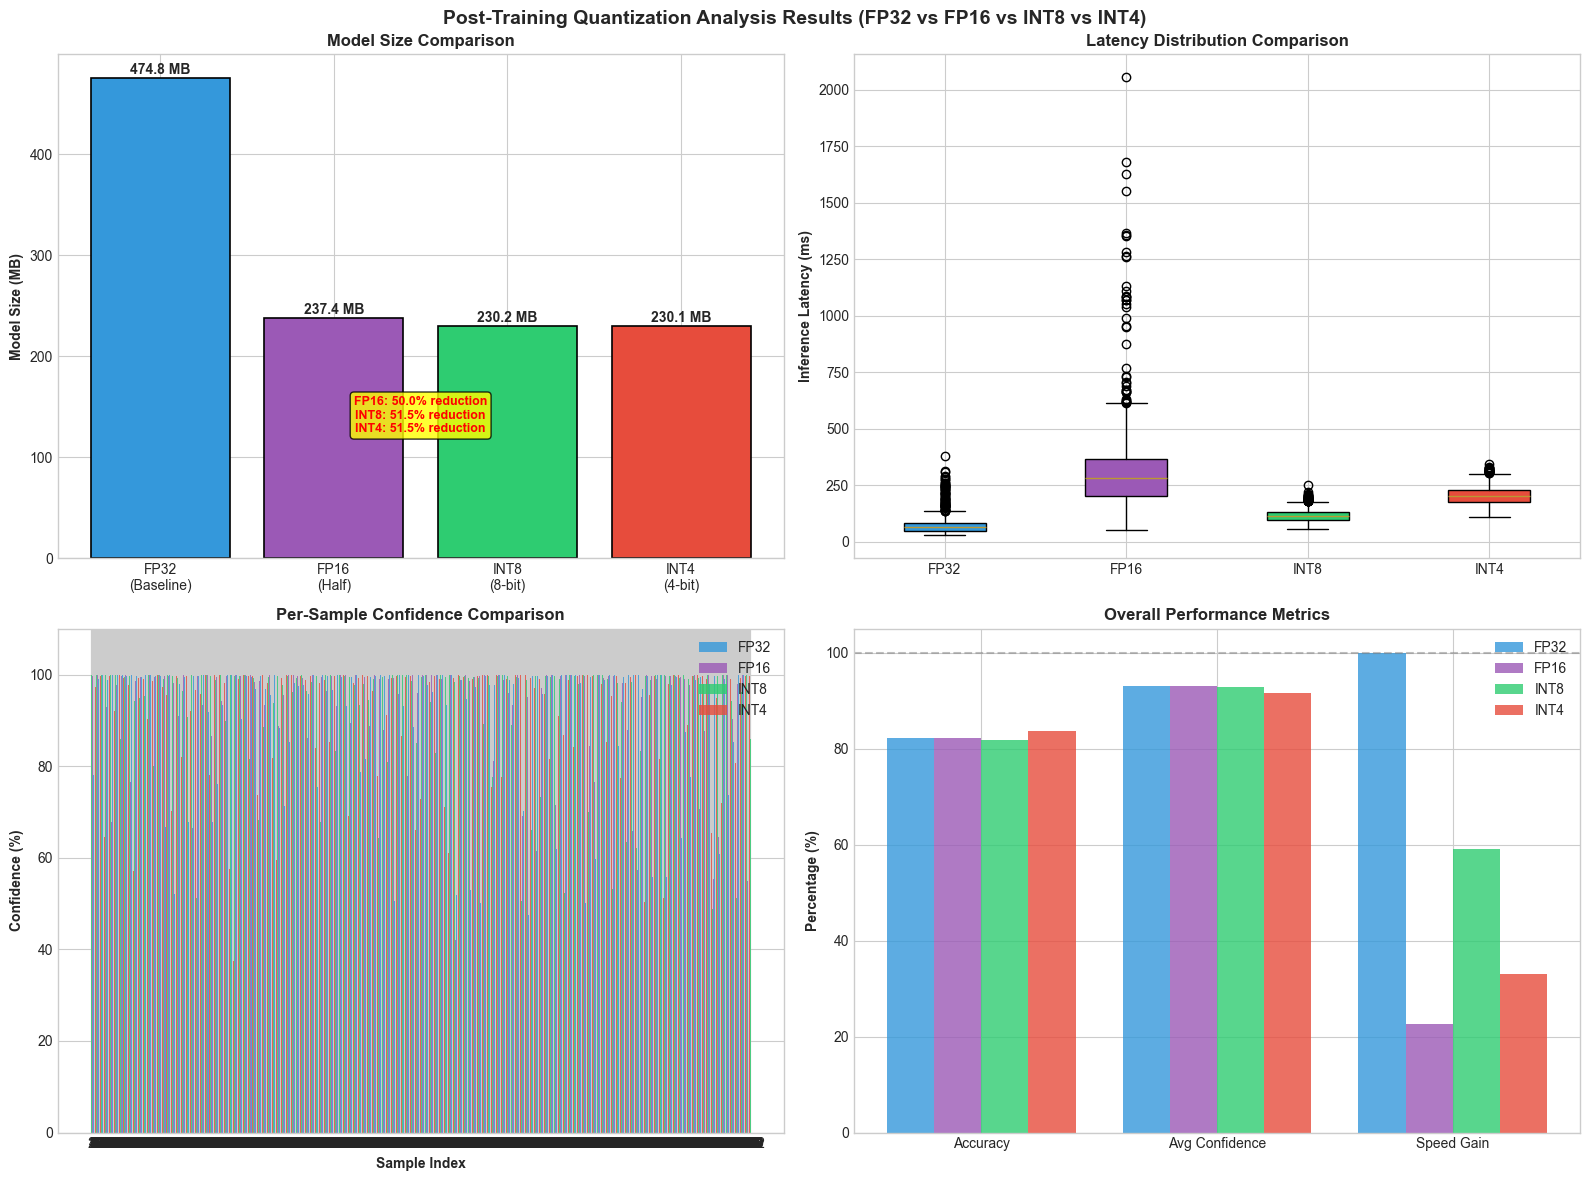


✓ Visualization saved to: ./finetuned-tweets-outputs\quantization_analysis.png


In [33]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Post-Training Quantization Analysis Results (FP32 vs FP16 vs INT8 vs INT4)', fontsize=14, fontweight='bold')

ax1 = axes[0, 0]
sizes = [fp32_size_mb, fp16_size_mb, int8_size_mb, int4_size_mb]
labels = ['FP32\n(Baseline)', 'FP16\n(Half)', 'INT8\n(8-bit)', 'INT4\n(4-bit)']
colors = ['#3498db', '#9b59b6', '#2ecc71', '#e74c3c']
bars = ax1.bar(labels, sizes, color=colors, edgecolor='black', linewidth=1.2)
ax1.set_ylabel('Model Size (MB)', fontweight='bold')
ax1.set_title('Model Size Comparison', fontweight='bold')
for bar, size in zip(bars, sizes):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{size:.1f} MB', ha='center', va='bottom', fontweight='bold')
fp16_reduction = (1 - fp16_size_mb/fp32_size_mb) * 100
int8_reduction = (1 - int8_size_mb/fp32_size_mb) * 100
int4_reduction = (1 - int4_size_mb/fp32_size_mb) * 100
ax1.annotate(f'FP16: {fp16_reduction:.1f}% reduction\nINT8: {int8_reduction:.1f}% reduction\nINT4: {int4_reduction:.1f}% reduction', 
             xy=(0.5, 0.25), xycoords='axes fraction',
             fontsize=9, ha='center', color='red', fontweight='bold',
             bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8))

ax2 = axes[0, 1]
latency_data = [np.array(fp32_results['latencies'])*1000, 
                np.array(fp16_results['latencies'])*1000,
                np.array(int8_results['latencies'])*1000,
                np.array(int4_results['latencies'])*1000]
bp = ax2.boxplot(latency_data, labels=['FP32', 'FP16', 'INT8', 'INT4'], patch_artist=True)
bp['boxes'][0].set_facecolor('#3498db')
bp['boxes'][1].set_facecolor('#9b59b6')
bp['boxes'][2].set_facecolor('#2ecc71')
bp['boxes'][3].set_facecolor('#e74c3c')
ax2.set_ylabel('Inference Latency (ms)', fontweight='bold')
ax2.set_title('Latency Distribution Comparison', fontweight='bold')

ax3 = axes[1, 0]
x = np.arange(len(TEST_SAMPLES))
width = 0.2
ax3.bar(x - 1.5*width, [p['confidence']*100 for p in fp32_results['predictions']], 
        width, label='FP32', color='#3498db', alpha=0.8)
ax3.bar(x - 0.5*width, [p['confidence']*100 for p in fp16_results['predictions']], 
        width, label='FP16', color='#9b59b6', alpha=0.8)
ax3.bar(x + 0.5*width, [p['confidence']*100 for p in int8_results['predictions']], 
        width, label='INT8', color='#2ecc71', alpha=0.8)
ax3.bar(x + 1.5*width, [p['confidence']*100 for p in int4_results['predictions']], 
        width, label='INT4', color='#e74c3c', alpha=0.8)
ax3.set_xlabel('Sample Index', fontweight='bold')
ax3.set_ylabel('Confidence (%)', fontweight='bold')
ax3.set_title('Per-Sample Confidence Comparison', fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels([str(i+1) for i in x])
ax3.legend()
ax3.set_ylim(0, 110)

ax4 = axes[1, 1]
metrics = ['Accuracy', 'Avg Confidence', 'Speed Gain']
fp32_vals = [fp32_results['accuracy']*100, fp32_results['avg_confidence']*100, 100]
speedup_fp16 = (fp32_results['latency_stats']['mean'] / fp16_results['latency_stats']['mean']) * 100 if fp16_results['latency_stats']['mean'] > 0 else 100
speedup_int8 = (fp32_results['latency_stats']['mean'] / int8_results['latency_stats']['mean']) * 100 if int8_results['latency_stats']['mean'] > 0 else 100
speedup_int4 = (fp32_results['latency_stats']['mean'] / int4_results['latency_stats']['mean']) * 100 if int4_results['latency_stats']['mean'] > 0 else 100
fp16_vals = [fp16_results['accuracy']*100, fp16_results['avg_confidence']*100, speedup_fp16]
int8_vals = [int8_results['accuracy']*100, int8_results['avg_confidence']*100, speedup_int8]
int4_vals = [int4_results['accuracy']*100, int4_results['avg_confidence']*100, speedup_int4]

x = np.arange(len(metrics))
ax4.bar(x - 1.5*width, fp32_vals, width, label='FP32', color='#3498db', alpha=0.8)
ax4.bar(x - 0.5*width, fp16_vals, width, label='FP16', color='#9b59b6', alpha=0.8)
ax4.bar(x + 0.5*width, int8_vals, width, label='INT8', color='#2ecc71', alpha=0.8)
ax4.bar(x + 1.5*width, int4_vals, width, label='INT4', color='#e74c3c', alpha=0.8)
ax4.set_ylabel('Percentage (%)', fontweight='bold')
ax4.set_title('Overall Performance Metrics', fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(metrics)
ax4.legend()
ax4.axhline(y=100, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['output_dir'], 'quantization_analysis.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Visualization saved to: {os.path.join(CONFIG['output_dir'], 'quantization_analysis.png')}")

## 9. Conclusions <a id="9-conclusions"></a>

In [34]:
print("="*80)
print("RESEARCH CONCLUSIONS")
print("="*80)



RESEARCH CONCLUSIONS
